# Autoencoder

## 1. Settings

### 1) Import required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

## 2. Data

### 1) Download Data

In [4]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [6]:
mnist_train[0][1]           # label

2

### 2) Set DataLoader

In [7]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [8]:
len(dataloaders["train"])

196

## 3. Model & Optimizer

### 1) Model

In [15]:
# build your own autoencoder
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 32),
            nn.ReLU()                    # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 784),
            nn.Sigmoid()                  # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                    # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)          # final output. resize to input's size
        return out, encoded


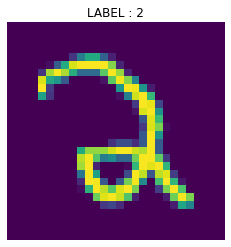

In [16]:
plt.imshow(mnist_train[0][0].squeeze())
plt.title(f"LABEL : {mnist_train[0][1]}")
plt.axis('off')
plt.show()

### 2) Loss func & Optimizer

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [19]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10): 
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode : Evaluationg때와 train때 하는 행동이 다름 (Batch Normalization 등)

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [23]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0248
val Loss: 0.0244

Epoch 1/29
----------
train Loss: 0.0235
val Loss: 0.0232

Epoch 2/29
----------
train Loss: 0.0224
val Loss: 0.0222

Epoch 3/29
----------
train Loss: 0.0214
val Loss: 0.0213

Epoch 4/29
----------
train Loss: 0.0206
val Loss: 0.0205

Epoch 5/29
----------
train Loss: 0.0198
val Loss: 0.0197

Epoch 6/29
----------
train Loss: 0.0190
val Loss: 0.0190

Epoch 7/29
----------
train Loss: 0.0183
val Loss: 0.0183

Epoch 8/29
----------
train Loss: 0.0177
val Loss: 0.0177

Epoch 9/29
----------
train Loss: 0.0171
val Loss: 0.0172

Epoch 10/29
----------
train Loss: 0.0167
val Loss: 0.0168

Epoch 11/29
----------
train Loss: 0.0163
val Loss: 0.0165

Epoch 12/29
----------
train Loss: 0.0160
val Loss: 0.0162

Epoch 13/29
----------
train Loss: 0.0157
val Loss: 0.0159

Epoch 14/29
----------
train Loss: 0.0154
val Loss: 0.0156

Epoch 15/29
----------
train Loss: 0.0151
val Loss: 0.0153

Epoch 16/29
----------
train Loss: 0.0149
val Loss

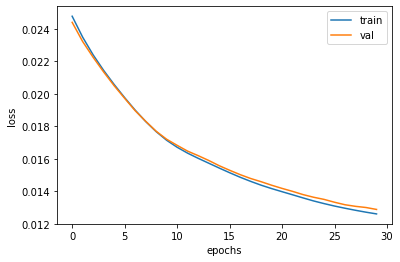

In [24]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 5. Check with Test Image

In [25]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.01227355889827013


torch.Size([16, 28, 28])


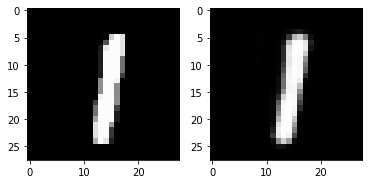

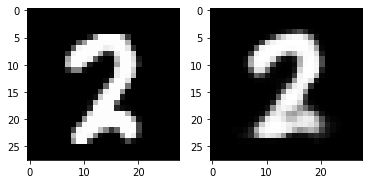

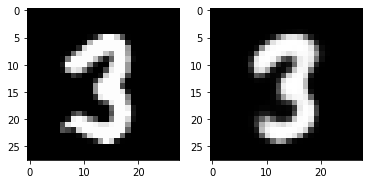

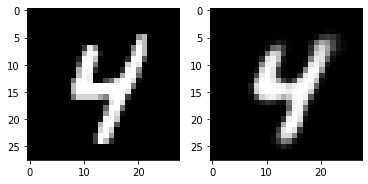

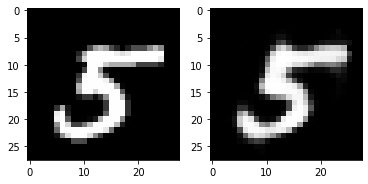

In [26]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [27]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [28]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [29]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

In [30]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded) # 저차원에 매핑되어 있는 Latent Vector를 Transform하는게 2D차원에 Mapping하는데 효과적이다.
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

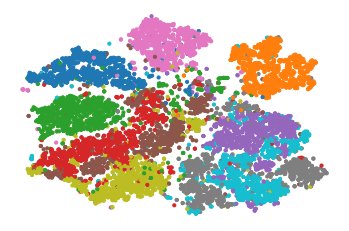

In [31]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

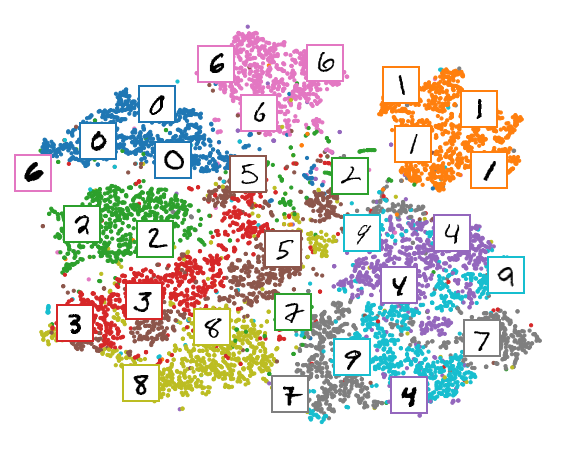

In [32]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [35]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [37]:
# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# Hint: You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode : Evaluationg때와 train때 하는 행동이 다름 (Batch Normalization 등)

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28)
                inputs += nn.init.normal_(noise, 0, 0.1)

                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)                          # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)


    return model, train_loss_history, val_loss_history

In [39]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0770
val Loss: 0.0720

Epoch 1/29
----------
train Loss: 0.0668
val Loss: 0.0626

Epoch 2/29
----------
train Loss: 0.0571
val Loss: 0.0538

Epoch 3/29
----------
train Loss: 0.0508
val Loss: 0.0492

Epoch 4/29
----------
train Loss: 0.0469
val Loss: 0.0456

Epoch 5/29
----------
train Loss: 0.0433
val Loss: 0.0420

Epoch 6/29
----------
train Loss: 0.0400
val Loss: 0.0390

Epoch 7/29
----------
train Loss: 0.0375
val Loss: 0.0368

Epoch 8/29
----------
train Loss: 0.0355
val Loss: 0.0351

Epoch 9/29
----------
train Loss: 0.0340
val Loss: 0.0337

Epoch 10/29
----------
train Loss: 0.0329
val Loss: 0.0328

Epoch 11/29
----------
train Loss: 0.0320
val Loss: 0.0319

Epoch 12/29
----------
train Loss: 0.0312
val Loss: 0.0312

Epoch 13/29
----------
train Loss: 0.0306
val Loss: 0.0306

Epoch 14/29
----------
train Loss: 0.0300
val Loss: 0.0300

Epoch 15/29
----------
train Loss: 0.0295
val Loss: 0.0295

Epoch 16/29
----------
train Loss: 0.0290
val Loss

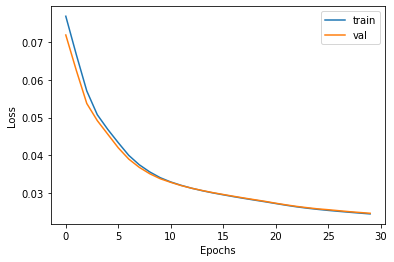

In [40]:
plt.plot(train_loss_history_D)
plt.plot(val_loss_history_D)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [41]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test'] : 
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.01429784672409296


torch.Size([16, 28, 28])


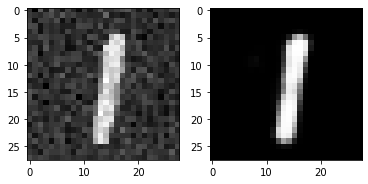

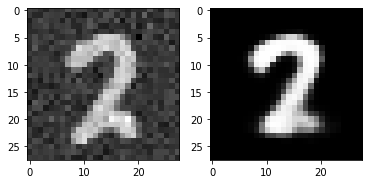

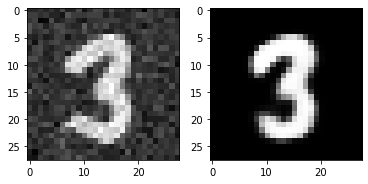

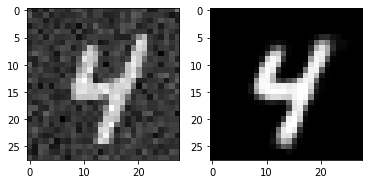

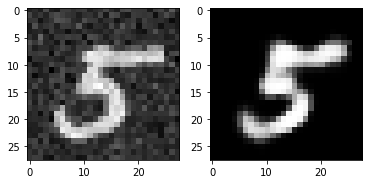

In [42]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()